<a href="https://colab.research.google.com/github/bioinformaticsproject/Subcellular-Localization-Prediction-of-Human-Proteins-Using-Sequence-Based-Machine-Learning-Models-/blob/main/protein_localization_ml_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week 1 — Data Preparation, EDA & AAC Baseline


In [ ]:
DATA_PATH = "/content/deeploc_data.csv"

# Imports & global config

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
plt.rcParams["figure.dpi"] = 120


# Load dataset & basic EDA

In [ ]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (14004, 3)


,ID,Location,Sequence
0,Q9H400,Cell.membrane,MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...
1,Q5I0E9,Cell.membrane,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...
2,P63033,Cell.membrane,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...
3,Q9NR71,Cell.membrane,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...
4,Q86XT9,Cell.membrane,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...


Add sequence length column

In [ ]:
df["seq_len"] = df["Sequence"].str.len()

print("\nClass counts:")
print(df["Location"].value_counts())

print("\nSequence length stats:")
print(df["seq_len"].describe())



Class counts:
Location
Nucleus                  4043
Cytoplasm                2688
Extracellular            1973
Mitochondrion            1510
Cell.membrane            1340
Endoplasmic.reticulum     862
Plastid                   757
Golgi.apparatus           356
Lysosome/Vacuole          321
Peroxisome                154
Name: count, dtype: int64

Sequence length stats:
count    14004.00000
mean       522.44166
std        448.06671
min         40.00000
25%        249.00000
50%        421.00000
75%        649.00000
max      13100.00000
Name: seq_len, dtype: float64


Plot class distribution

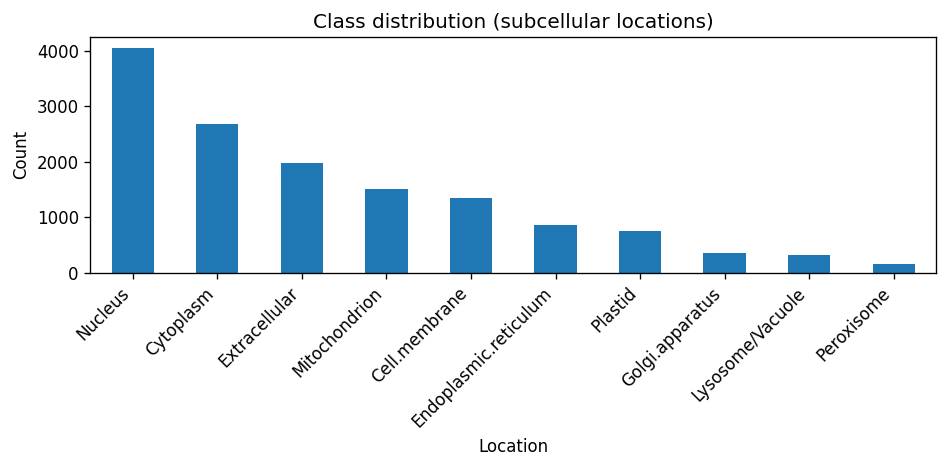

In [ ]:
plt.figure(figsize=(8,4))
df["Location"].value_counts().plot(kind="bar")
plt.title("Class distribution (subcellular locations)")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Plot sequence length distribution

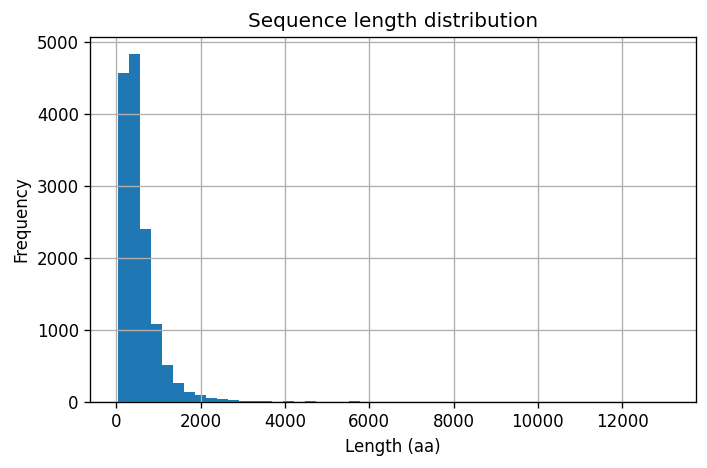

In [ ]:
plt.figure(figsize=(6,4))
df["seq_len"].hist(bins=50)
plt.title("Sequence length distribution")
plt.xlabel("Length (aa)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Label encoding

In [ ]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Location"])

class_names = label_encoder.classes_
print("Encoded classes:")
for i, c in enumerate(class_names):
    print(i, "->", c)

Encoded classes:
0 -> Cell.membrane
1 -> Cytoplasm
2 -> Endoplasmic.reticulum
3 -> Extracellular
4 -> Golgi.apparatus
5 -> Lysosome/Vacuole
6 -> Mitochondrion
7 -> Nucleus
8 -> Peroxisome
9 -> Plastid


AAC feature extraction

In [ ]:
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")  # 20 standard AA

def compute_aac(seq: str):
    """
    Amino-acid composition (frequency of each amino acid).
    Returns a 20-dim vector.
    """
    seq = str(seq).upper()
    counts = Counter([aa for aa in seq if aa in AMINO_ACIDS])
    total = sum(counts.values())
    if total == 0:
        return np.zeros(len(AMINO_ACIDS))
    return np.array([counts[aa] / total for aa in AMINO_ACIDS])

Build AAC feature matrix

In [ ]:
aac_features = np.vstack(df["Sequence"].apply(compute_aac).values)
print("AAC feature matrix shape:", aac_features.shape)

AAC feature matrix shape: (14004, 20)


Train/test split + scaling

In [ ]:
X_aac = aac_features
y = df["label"].values

X_train_aac, X_test_aac, y_train, y_test = train_test_split(
    X_aac, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train shape:", X_train_aac.shape)
print("Test shape:", X_test_aac.shape)

Train shape: (11203, 20)
Test shape: (2801, 20)


Standardize for SVM / MLP

In [ ]:
scaler_aac = StandardScaler()
X_train_aac_scaled = scaler_aac.fit_transform(X_train_aac)
X_test_aac_scaled = scaler_aac.transform(X_test_aac)

Helper: evaluation function

In [ ]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, labels=None):
    print(f"\n===== {name} =====")
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print("Accuracy:", acc)
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, target_names=labels))

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(6,6))
    disp.plot(include_values=False, xticks_rotation=45, cmap="Blues")
    plt.title(f"Confusion matrix – {name}")
    plt.tight_layout()
    plt.show()

    return acc

# **Week 1 baseline models (AAC only)**

# Random Forest baseline (AAC)


===== RF (AAC baseline) =====
Accuracy: 0.5608711174580507

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.58      0.57      0.58       268
            Cytoplasm       0.43      0.43      0.43       538
Endoplasmic.reticulum       0.56      0.30      0.39       172
        Extracellular       0.72      0.74      0.73       395
      Golgi.apparatus       1.00      0.10      0.18        71
     Lysosome/Vacuole       0.88      0.11      0.19        64
        Mitochondrion       0.51      0.38      0.43       302
              Nucleus       0.56      0.83      0.67       809
           Peroxisome       0.00      0.00      0.00        31
              Plastid       0.59      0.31      0.41       151

             accuracy                           0.56      2801
            macro avg       0.58      0.38      0.40      2801
         weighted avg       0.57      0.56      0.54      2801



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 720x720 with 0 Axes>

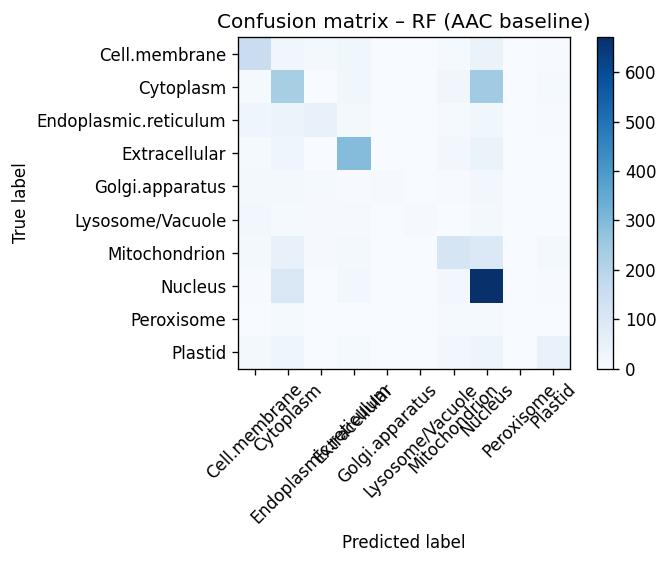

In [ ]:
rf_aac = RandomForestClassifier(
    n_estimators=200,
    random_state=SEED,
    n_jobs=-1
)
acc_rf_aac = evaluate_model(
    "RF (AAC baseline)",
    rf_aac,
    X_train_aac, y_train,
    X_test_aac, y_test,
    labels=class_names
)

# SVM baseline (AAC + scaling)


===== SVM (AAC baseline) =====
Accuracy: 0.5562299178864691

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.58      0.54      0.56       268
            Cytoplasm       0.40      0.33      0.37       538
Endoplasmic.reticulum       0.56      0.30      0.39       172
        Extracellular       0.71      0.74      0.72       395
      Golgi.apparatus       1.00      0.01      0.03        71
     Lysosome/Vacuole       1.00      0.03      0.06        64
        Mitochondrion       0.54      0.50      0.52       302
              Nucleus       0.56      0.83      0.67       809
           Peroxisome       0.00      0.00      0.00        31
              Plastid       0.55      0.42      0.48       151

             accuracy                           0.56      2801
            macro avg       0.59      0.37      0.38      2801
         weighted avg       0.56      0.56      0.53      2801



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 720x720 with 0 Axes>

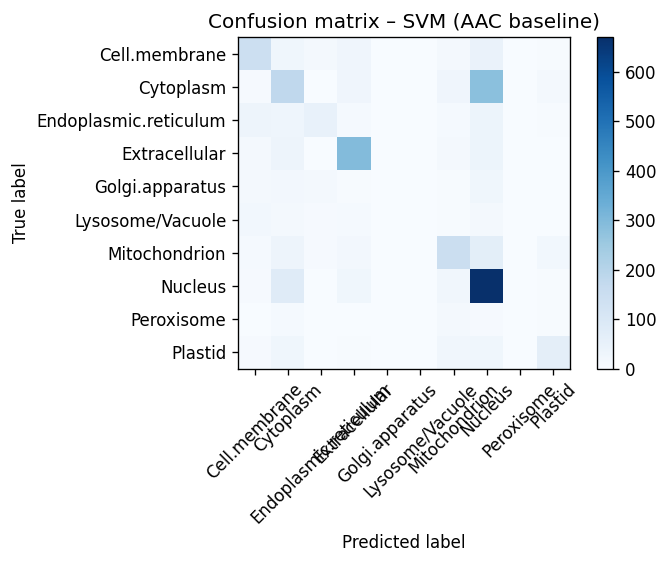

In [ ]:
svm_aac = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=SEED
)
acc_svm_aac = evaluate_model(
    "SVM (AAC baseline)",
    svm_aac,
    X_train_aac_scaled, y_train,
    X_test_aac_scaled, y_test,
    labels=class_names
)

# MLP baseline (AAC + scaling)


===== MLP (AAC baseline) =====
Accuracy: 0.5319528739735808

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.56      0.50      0.53       268
            Cytoplasm       0.42      0.43      0.43       538
Endoplasmic.reticulum       0.36      0.37      0.36       172
        Extracellular       0.72      0.66      0.69       395
      Golgi.apparatus       0.27      0.14      0.19        71
     Lysosome/Vacuole       0.23      0.16      0.19        64
        Mitochondrion       0.47      0.48      0.48       302
              Nucleus       0.61      0.69      0.65       809
           Peroxisome       0.07      0.03      0.04        31
              Plastid       0.47      0.49      0.48       151

             accuracy                           0.53      2801
            macro avg       0.42      0.40      0.40      2801
         weighted avg       0.52      0.53      0.53      2801



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 720x720 with 0 Axes>

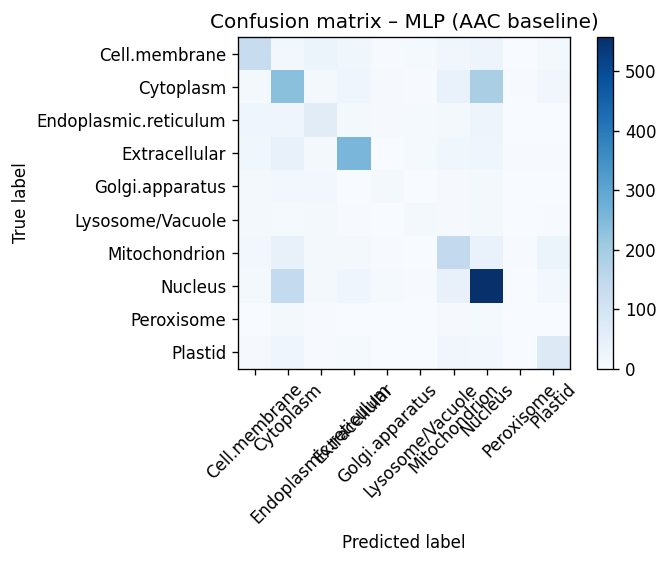

In [ ]:
mlp_aac = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    random_state=SEED,
    max_iter=200
)
acc_mlp_aac = evaluate_model(
    "MLP (AAC baseline)",
    mlp_aac,
    X_train_aac_scaled, y_train,
    X_test_aac_scaled, y_test,
    labels=class_names
)


# Week 1 AAC Accuracies

In [ ]:
print("\nWeek 1 AAC Accuracies: \n")
print("RF :", acc_rf_aac)
print("SVM:", acc_svm_aac)
print("MLP:", acc_mlp_aac)


Week 1 AAC Accuracies: 

RF : 0.5608711174580507
SVM: 0.5562299178864691
MLP: 0.5319528739735808


## Week 2 — Protein Embeddings (ESM) + Stronger Models

**Install transformers**

In [ ]:
!pip install -q transformers accelerate

# **Load ESM model**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
MODEL_NAME = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
esm_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
esm_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=320, out_features=1280, bias=True)
        )
        (output): EsmOutput(
        

# Embedding function

In [ ]:
MAX_LEN = 1024  # truncating  very long proteins

def embed_sequence(seq: str) -> np.ndarray:
    """
    Get a single fixed-length embedding for one protein
    by mean-pooling token embeddings from ESM-2.
    """
    seq = str(seq)[:MAX_LEN]

    with torch.no_grad():
        tokens = tokenizer(
            seq,
            return_tensors="pt",
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}
        outputs = esm_model(**tokens)
        # last_hidden_state: (1, L, hidden_dim)
        emb = outputs.last_hidden_state.mean(dim=1)

    return emb.cpu().numpy().squeeze()


# Compute embeddings for all sequences

In [ ]:
emb_list = []
for seq in tqdm(df["Sequence"], desc="Embedding sequences"):
    emb = embed_sequence(seq)
    emb_list.append(emb)

X_emb = np.vstack(emb_list)
print("Embedding matrix shape:", X_emb.shape)

Embedding sequences:   0%|          | 0/14004 [00:00<?, ?it/s]

Embedding matrix shape: (14004, 320)


save to .npy so you don’t recompute

In [ ]:
np.save("X_emb.npy", X_emb)
np.save("y_labels.npy", y)

# Train/test split + scaling (embeddings)

In [ ]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train (emb):", X_train_emb.shape)
print("Test (emb):", X_test_emb.shape)

scaler_emb = StandardScaler()
X_train_emb_scaled = scaler_emb.fit_transform(X_train_emb)
X_test_emb_scaled = scaler_emb.transform(X_test_emb)


Train (emb): (11203, 320)
Test (emb): (2801, 320)


# Class weights for imbalance

In [ ]:
classes = np.unique(y)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)


Class weights: {np.int64(0): np.float64(1.0450746268656717), np.int64(1): np.float64(0.5209821428571428), np.int64(2): np.float64(1.6245939675174015), np.int64(3): np.float64(0.7097820577800305), np.int64(4): np.float64(3.9337078651685395), np.int64(5): np.float64(4.3626168224299064), np.int64(6): np.float64(0.9274172185430464), np.int64(7): np.float64(0.3463764531288647), np.int64(8): np.float64(9.093506493506494), np.int64(9): np.float64(1.8499339498018494)}


# Week 2 models on ESM embeddings

**RF on embeddings**


===== RF (ESM embeddings) =====
Accuracy: 0.694394858978936

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.74      0.72      0.73       268
            Cytoplasm       0.57      0.50      0.53       538
Endoplasmic.reticulum       0.70      0.45      0.55       172
        Extracellular       0.82      0.90      0.86       395
      Golgi.apparatus       0.87      0.37      0.51        71
     Lysosome/Vacuole       0.83      0.16      0.26        64
        Mitochondrion       0.74      0.63      0.68       302
              Nucleus       0.66      0.90      0.76       809
           Peroxisome       0.82      0.29      0.43        31
              Plastid       0.80      0.58      0.67       151

             accuracy                           0.69      2801
            macro avg       0.75      0.55      0.60      2801
         weighted avg       0.70      0.69      0.68      2801



<Figure size 720x720 with 0 Axes>

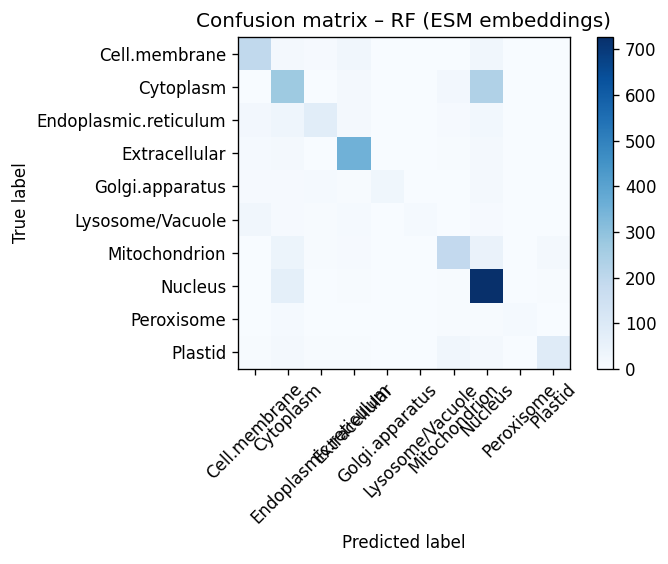

In [ ]:
rf_emb = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=SEED,
    n_jobs=-1,
    class_weight=class_weight_dict
)
acc_rf_emb = evaluate_model(
    "RF (ESM embeddings)",
    rf_emb,
    X_train_emb, y_train_emb,
    X_test_emb, y_test_emb,
    labels=class_names
)

**SVM (RBF) on embeddings + scaling + class_weight**


===== SVM (ESM embeddings) =====
Accuracy: 0.7483041770796144

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.83      0.71      0.76       268
            Cytoplasm       0.61      0.69      0.64       538
Endoplasmic.reticulum       0.65      0.63      0.64       172
        Extracellular       0.91      0.91      0.91       395
      Golgi.apparatus       0.53      0.59      0.56        71
     Lysosome/Vacuole       0.47      0.44      0.45        64
        Mitochondrion       0.76      0.73      0.75       302
              Nucleus       0.82      0.78      0.80       809
           Peroxisome       0.46      0.55      0.50        31
              Plastid       0.77      0.85      0.81       151

             accuracy                           0.75      2801
            macro avg       0.68      0.69      0.68      2801
         weighted avg       0.75      0.75      0.75      2801



<Figure size 720x720 with 0 Axes>

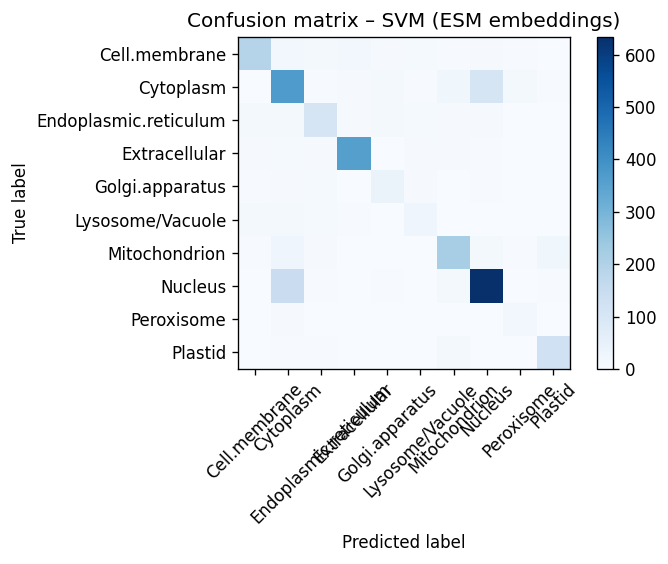

In [ ]:
svm_emb = SVC(
    kernel="rbf",
    C=2.0,
    gamma="scale",
    class_weight="balanced",
    random_state=SEED
)
acc_svm_emb = evaluate_model(
    "SVM (ESM embeddings)",
    svm_emb,
    X_train_emb_scaled, y_train_emb,
    X_test_emb_scaled, y_test_emb,
    labels=class_names
)

**MLP on embeddings + scaling (no class_weight directly)**


===== MLP (ESM embeddings) =====
Accuracy: 0.7350946090681899

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.77      0.80      0.78       268
            Cytoplasm       0.60      0.67      0.63       538
Endoplasmic.reticulum       0.70      0.47      0.56       172
        Extracellular       0.88      0.92      0.90       395
      Golgi.apparatus       0.58      0.46      0.52        71
     Lysosome/Vacuole       0.61      0.22      0.32        64
        Mitochondrion       0.71      0.74      0.73       302
              Nucleus       0.78      0.81      0.79       809
           Peroxisome       0.57      0.26      0.36        31
              Plastid       0.77      0.72      0.74       151

             accuracy                           0.74      2801
            macro avg       0.70      0.61      0.63      2801
         weighted avg       0.73      0.74      0.73      2801



<Figure size 720x720 with 0 Axes>

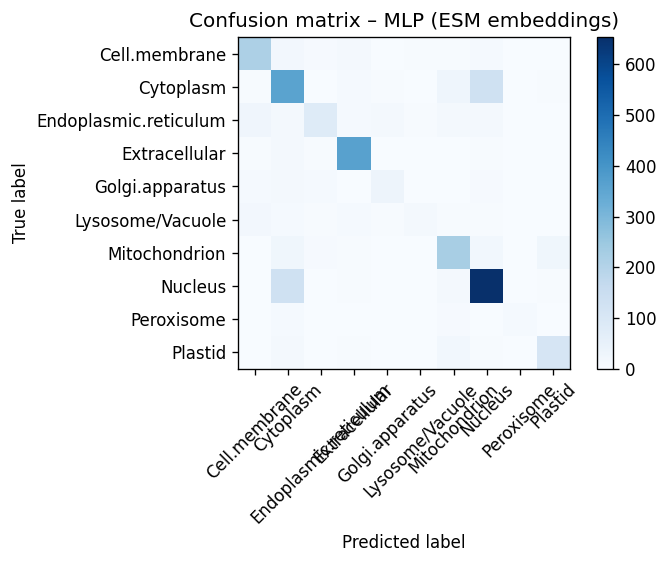

In [ ]:
mlp_emb = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    alpha=5e-4,
    batch_size=128,
    max_iter=80,
    early_stopping=True,
    random_state=SEED
)
acc_mlp_emb = evaluate_model(
    "MLP (ESM embeddings)",
    mlp_emb,
    X_train_emb_scaled, y_train_emb,
    X_test_emb_scaled, y_test_emb,
    labels=class_names
)

**Week 2 ESM Accuracies:**


In [ ]:
print("\nWeek 2 ESM Accuracies: \n")
print("RF :", acc_rf_emb)
print("SVM:", acc_svm_emb)
print("MLP:", acc_mlp_emb)


Week 2 ESM Accuracies: 

RF : 0.694394858978936
SVM: 0.7483041770796144
MLP: 0.7350946090681899


## Week 3 — Imbalance Handling, Hyperparameter Tuning, Plots & Saving

**Install imbalanced-learn (SMOTE)**

In [ ]:
!pip install -q imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)

X_train_aac_smote, y_train_smote = smote.fit_resample(X_train_aac, y_train)

print("Before SMOTE:", X_train_aac.shape, np.bincount(y_train))
print("After  SMOTE:", X_train_aac_smote.shape, np.bincount(y_train_smote))

Before SMOTE: (11203, 20) [1072 2150  690 1578  285  257 1208 3234  123  606]
After  SMOTE: (32340, 20) [3234 3234 3234 3234 3234 3234 3234 3234 3234 3234]


Scaling

In [ ]:
scaler_aac_smote = StandardScaler()
X_train_aac_smote_scaled = scaler_aac_smote.fit_transform(X_train_aac_smote)
X_test_aac_smote_scaled = scaler_aac_smote.transform(X_test_aac)

# RF on AAC + SMOTE (improved baseline)


===== RF (AAC + SMOTE) =====
Accuracy: 0.5787218850410568

Classification report:
                       precision    recall  f1-score   support

        Cell.membrane       0.64      0.54      0.59       268
            Cytoplasm       0.50      0.46      0.48       538
Endoplasmic.reticulum       0.41      0.43      0.42       172
        Extracellular       0.74      0.73      0.74       395
      Golgi.apparatus       0.36      0.28      0.32        71
     Lysosome/Vacuole       0.42      0.28      0.34        64
        Mitochondrion       0.46      0.50      0.48       302
              Nucleus       0.67      0.72      0.69       809
           Peroxisome       0.21      0.23      0.22        31
              Plastid       0.48      0.58      0.53       151

             accuracy                           0.58      2801
            macro avg       0.49      0.48      0.48      2801
         weighted avg       0.58      0.58      0.58      2801



<Figure size 720x720 with 0 Axes>

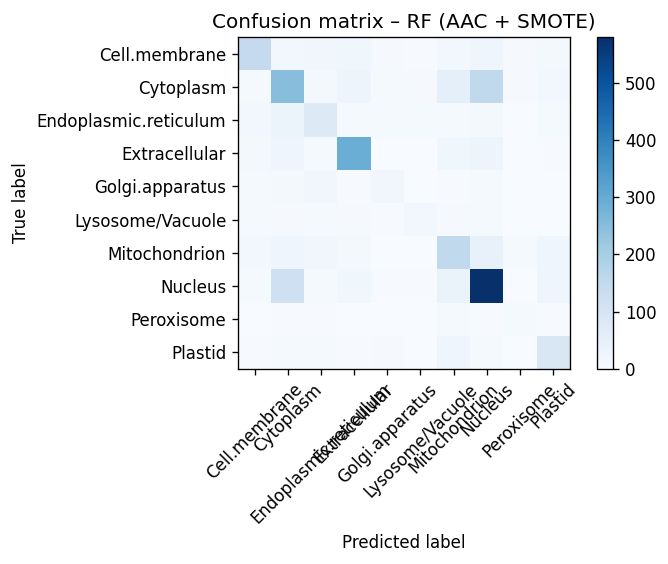

RF (AAC + SMOTE) accuracy: 0.5787218850410568


In [ ]:
rf_aac_smote = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1
)

acc_rf_aac_smote = evaluate_model(
    "RF (AAC + SMOTE)",
    rf_aac_smote,
    X_train_aac_smote, y_train_smote,
    X_test_aac, y_test,
    labels=class_names
)

print("RF (AAC + SMOTE) accuracy:", acc_rf_aac_smote)

**Hyperparameter tuning for RF on embeddings**

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best RF params (ESM):
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}

Tuned RF (ESM) accuracy: 0.6990360585505176

Classification report – Tuned RF (ESM):
                       precision    recall  f1-score   support

        Cell.membrane       0.76      0.71      0.73       268
            Cytoplasm       0.58      0.55      0.57       538
Endoplasmic.reticulum       0.59      0.50      0.54       172
        Extracellular       0.83      0.90      0.86       395
      Golgi.apparatus       0.78      0.39      0.52        71
     Lysosome/Vacuole       0.73      0.25      0.37        64
        Mitochondrion       0.66      0.70      0.68       302
              Nucleus       0.72      0.82      0.76       809
           Peroxisome       0.71      0.39      0.50        31
              Plastid       0.71      0.65      0.68       151

             accuracy                           0

<Figure size 720x720 with 0 Axes>

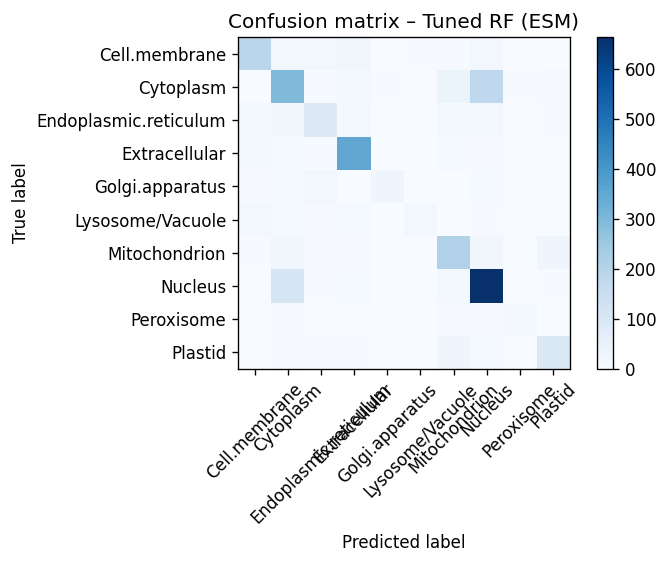

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "n_estimators": [300, 500, 800],
    "max_depth": [20, 40, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_base = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1,
    class_weight=class_weight_dict
)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring="f1_macro",
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_emb, y_train_emb)

print("\nBest RF params (ESM):")
print(rf_search.best_params_)

best_rf_emb = rf_search.best_estimator_

y_pred_best_rf = best_rf_emb.predict(X_test_emb)
acc_best_rf = accuracy_score(y_test_emb, y_pred_best_rf)

print("\nTuned RF (ESM) accuracy:", acc_best_rf)
print("\nClassification report – Tuned RF (ESM):")
print(classification_report(y_test_emb, y_pred_best_rf, target_names=class_names))

cm = confusion_matrix(y_test_emb, y_pred_best_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(6,6))
disp.plot(include_values=False, xticks_rotation=45, cmap="Blues")
plt.title("Confusion matrix – Tuned RF (ESM)")
plt.tight_layout()
plt.show()

# Accuracy comparison plot

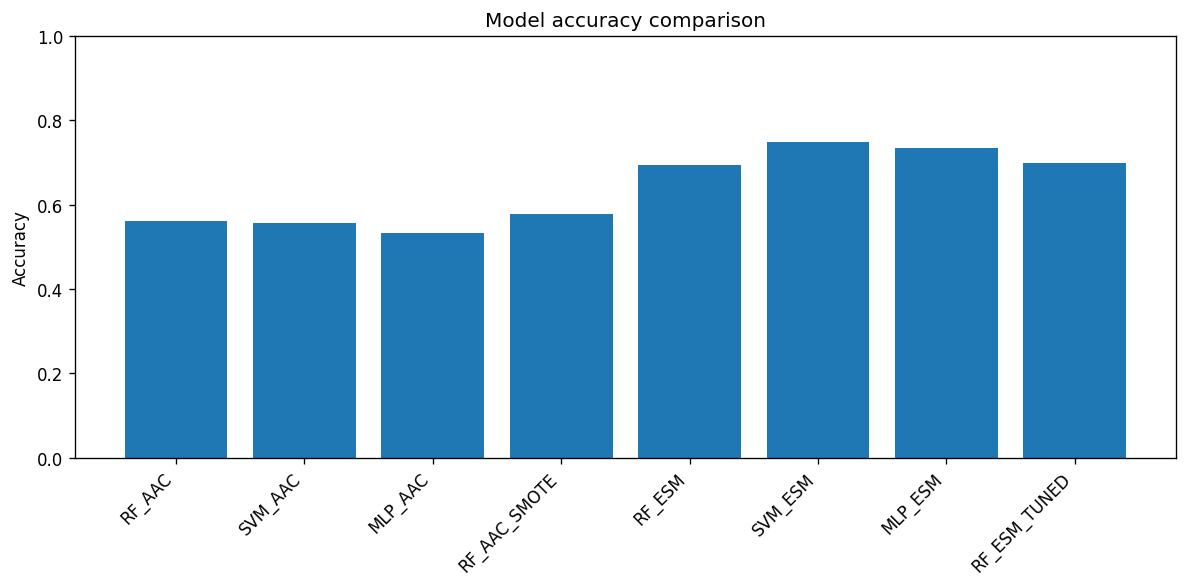

In [ ]:
model_names = [
    "RF_AAC",
    "SVM_AAC",
    "MLP_AAC",
    "RF_AAC_SMOTE",
    "RF_ESM",
    "SVM_ESM",
    "MLP_ESM",
    "RF_ESM_TUNED"
]

accuracies = [
    acc_rf_aac,
    acc_svm_aac,
    acc_mlp_aac,
    acc_rf_aac_smote,
    acc_rf_emb,
    acc_svm_emb,
    acc_mlp_emb,
    acc_best_rf
]

plt.figure(figsize=(10,5))
plt.bar(model_names, accuracies)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.title("Model accuracy comparison")
plt.tight_layout()
plt.show()

In [ ]:
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(label_encoder, "models/label_encoder.joblib")
joblib.dump(scaler_aac, "models/scaler_aac.joblib")
joblib.dump(scaler_emb, "models/scaler_emb.joblib")
joblib.dump(rf_aac_smote, "models/rf_aac_smote.joblib")
joblib.dump(best_rf_emb, "models/best_rf_esm.joblib")

np.save("models/X_emb.npy", X_emb)
np.save("models/y_labels.npy", y)

print("Saved models & arrays into 'models/' folder.")


Saved models & arrays into 'models/' folder.


# RandomizedSearchCV for SVM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np

# Base SVM (same as before but without fixed C/gamma)

In [ ]:
svm_base = SVC(
    kernel="rbf",
    class_weight="balanced",
    random_state=SEED
)


# Search space: try a range of C and gamma

In [ ]:
param_dist_svm = {
    "C": np.logspace(-2, 2, 10),
    "gamma": ["scale"] + list(np.logspace(-4, 0, 10))
}

svm_search = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_dist_svm,
    n_iter=40,
    cv=3,
    scoring="f1_macro",
    random_state=SEED,
    n_jobs=-1,
    verbose=2
)

svm_search.fit(X_train_emb_scaled, y_train_emb)

print("\nBest SVM params (ESM):")
print(svm_search.best_params_)
print("Best CV macro-F1:", svm_search.best_score_)

best_svm_esm = svm_search.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best SVM params (ESM):
{'gamma': np.float64(0.002154434690031882), 'C': np.float64(12.915496650148826)}
Best CV macro-F1: 0.6762904061515785


Tuned SVM (ESM) test accuracy: 0.7661549446626205

Classification report – Tuned SVM (ESM):
                       precision    recall  f1-score   support

        Cell.membrane       0.80      0.77      0.78       268
            Cytoplasm       0.65      0.71      0.68       538
Endoplasmic.reticulum       0.63      0.64      0.63       172
        Extracellular       0.92      0.91      0.91       395
      Golgi.apparatus       0.65      0.55      0.60        71
     Lysosome/Vacuole       0.53      0.39      0.45        64
        Mitochondrion       0.77      0.76      0.77       302
              Nucleus       0.82      0.81      0.82       809
           Peroxisome       0.62      0.52      0.56        31
              Plastid       0.81      0.80      0.80       151

             accuracy                           0.77      2801
            macro avg       0.72      0.69      0.70      2801
         weighted avg       0.77      0.77      0.77      2801



<Figure size 720x720 with 0 Axes>

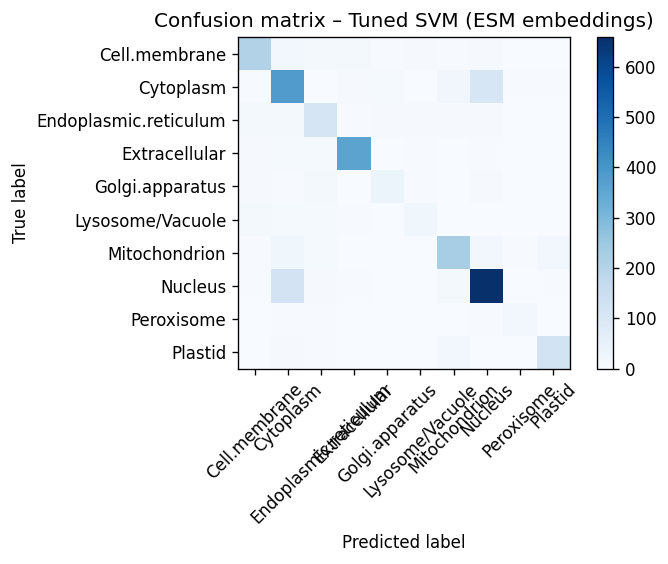

In [ ]:
y_pred_svm_tuned = best_svm_esm.predict(X_test_emb_scaled)

acc_svm_tuned = accuracy_score(y_test_emb, y_pred_svm_tuned)
print("Tuned SVM (ESM) test accuracy:", acc_svm_tuned)

print("\nClassification report – Tuned SVM (ESM):")
print(classification_report(y_test_emb, y_pred_svm_tuned, target_names=class_names))

cm = confusion_matrix(y_test_emb, y_pred_svm_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(6,6))
disp.plot(include_values=False, xticks_rotation=45, cmap="Blues")
plt.title("Confusion matrix – Tuned SVM (ESM embeddings)")
plt.tight_layout()
plt.show()


In [ ]:
import os
import joblib

os.makedirs("models", exist_ok=True)

# Saving tuned SVM (ESM)
joblib.dump(best_svm_esm, "models/best_svm_esm_tuned.joblib")

print("Saved tuned SVM model to: models/best_svm_esm_tuned.joblib")

Saved tuned SVM model to: models/best_svm_esm_tuned.joblib


In [ ]:
from sklearn.metrics import f1_score

model_names = [
    "RF_AAC",
    "SVM_AAC",
    "MLP_AAC",
    "RF_AAC_SMOTE",
    "RF_ESM",
    "SVM_ESM",
    "MLP_ESM",
    "RF_ESM_TUNED",
    "SVM_ESM_TUNED"
]

accuracies = [
    acc_rf_aac,
    acc_svm_aac,
    acc_mlp_aac,
    acc_rf_aac_smote,
    acc_rf_emb,
    acc_svm_emb,
    acc_mlp_emb,
    acc_best_rf,
    acc_svm_tuned
]


macro_f1 = {}

# 1) RF_ESM
y_pred_rf_esm = rf_emb.predict(X_test_emb)
macro_f1["RF_ESM"] = f1_score(y_test_emb, y_pred_rf_esm, average="macro")

# 2) SVM_ESM (original untuned)
y_pred_svm_esm = svm_emb.predict(X_test_emb_scaled)
macro_f1["SVM_ESM"] = f1_score(y_test_emb, y_pred_svm_esm, average="macro")

# 3) SVM_ESM_TUNED
macro_f1["SVM_ESM_TUNED"] = f1_score(y_test_emb, y_pred_svm_tuned, average="macro")

macro_f1


{'RF_ESM': 0.5990451119144858,
 'SVM_ESM': 0.6825326379030031,
 'SVM_ESM_TUNED': 0.6999588989492578}

# Model Accuracy Comparison

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=model_names,
    y=accuracies,
    marker_color='rgba(55, 128, 191, 0.7)',
))

fig.update_layout(
    title="Model Accuracy Comparison (AAC vs ESM)",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    yaxis=dict(range=[0,1]),
    template='plotly_white',
    width=900,
    height=500
)

fig.show()

# Macro-F1 Comparison for ESM Models

In [ ]:
mf1_names = list(macro_f1.keys())
mf1_values = list(macro_f1.values())

fig = go.Figure()

fig.add_trace(go.Bar(
    x=mf1_names,
    y=mf1_values,
    marker_color='rgba(255, 153, 51, 0.8)',
))

fig.update_layout(
    title="Macro F1-score Comparison – ESM Models",
    xaxis_title="Model",
    yaxis_title="Macro F1-score",
    yaxis=dict(range=[0,1]),
    template='plotly_white',
    width=700,
    height=450
)

fig.show()

# Per-Class Precision/Recall/F1 for Tuned SVM

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import plotly.graph_objects as go

prec, rec, f1, support = precision_recall_fscore_support(
    y_test_emb, y_pred_svm_tuned, labels=np.arange(len(class_names))
)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_names,
    y=prec,
    name='Precision',
    marker_color='rgba(99, 110, 250, 0.8)'
))

fig.add_trace(go.Bar(
    x=class_names,
    y=rec,
    name='Recall',
    marker_color='rgba(239, 85, 59, 0.8)'
))

fig.add_trace(go.Bar(
    x=class_names,
    y=f1,
    name='F1-score',
    marker_color='rgba(0, 204, 150, 0.8)'
))

fig.update_layout(
    barmode='group',
    title="Per-Class Performance – Tuned SVM (ESM Embeddings)",
    xaxis_title="Subcellular Location",
    yaxis_title="Score",
    yaxis=dict(range=[0,1]),
    template='plotly_white',
    width=1100,
    height=550
)

fig.show()


## Feature Space Visualization (t-SNE or UMAP of ESM embeddings)
Shows whether different subcellular compartments cluster in embedding space.

- Nucleus vs cytoplasm separation

- Signal-peptide-containing compartments (extracellular) cluster

- Rare classes overlap → explains lower accuracy

In [ ]:
!pip install umap-learn

import umap
import plotly.express as px

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_emb)

fig = px.scatter(
    x=X_umap[:,0],
    y=X_umap[:,1],
    color=[class_names[i] for i in y],
    title="UMAP Projection of Protein Embeddings (ESM-2)",
    labels={'x': 'UMAP-1', 'y': 'UMAP-2'},
    width=900, height=600
)
fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Error Analysis Heatmap (Misclassification Counts)

Shows which classes are confusing each other.

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np

cm = confusion_matrix(y_test_emb, y_pred_svm_tuned)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

fig = px.imshow(
    df_cm,
    text_auto=True,
    color_continuous_scale="Blues",
    title="Misclassification Heatmap – Tuned SVM",
    width=900, height=700
)
fig.show()


## Support Bar Chart (Class Distribution)

To visualize dataset imbalance.

In [ ]:
fig = px.bar(
    x=class_names,
    y=df['Location'].value_counts().sort_index(),
    title="Class Distribution (Subcellular Locations)",
    labels={'x': 'Class', 'y': 'Count'},
    width=900, height=450
)
fig.show()


# Sequence Length Distribution (Histogram)

In [ ]:
fig = px.histogram(
    df,
    x="seq_len",
    nbins=50,
    title="Sequence Length Distribution",
    width=900, height=450
)
fig.show()


# Model Confidence Histogram

In [ ]:
y_scores = best_svm_esm.decision_function(X_test_emb_scaled)
max_conf = y_scores.max(axis=1)

fig = px.histogram(
    x=max_conf,
    nbins=40,
    title="Prediction Confidence – Tuned SVM",
    width=900, height=450
)
fig.show()


In [ ]:
!pip install -q plotly umap-learn


## **DASHBOARD**

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import (
    confusion_matrix, f1_score, precision_recall_fscore_support,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import umap

# ----------------------------------------------------
# 1) UMAP 2D projection of ESM embeddings
# ----------------------------------------------------
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_emb)

y_class = np.array([class_names[i] for i in y])

# ----------------------------------------------------
# 2) Confusion matrix for tuned SVM (ESM)
# ----------------------------------------------------
cm = confusion_matrix(y_test_emb, y_pred_svm_tuned)

# ----------------------------------------------------
# 3) Accuracy for all models
# ----------------------------------------------------
model_names = [
    "RF_AAC",
    "SVM_AAC",
    "MLP_AAC",
    "RF_AAC_SMOTE",
    "RF_ESM",
    "SVM_ESM",
    "MLP_ESM",
    "RF_ESM_TUNED",
    "SVM_ESM_TUNED"
]

accuracies = [
    acc_rf_aac,
    acc_svm_aac,
    acc_mlp_aac,
    acc_rf_aac_smote,
    acc_rf_emb,
    acc_svm_emb,
    acc_mlp_emb,
    acc_best_rf,
    acc_svm_tuned
]

# ----------------------------------------------------
# 4) Macro-F1 for ESM models
# ----------------------------------------------------
macro_f1 = {}

# RF-ESM
y_pred_rf_esm = rf_emb.predict(X_test_emb)
macro_f1["RF_ESM"] = f1_score(y_test_emb, y_pred_rf_esm, average="macro")

# SVM-ESM (original)
y_pred_svm_esm = svm_emb.predict(X_test_emb_scaled)
macro_f1["SVM_ESM"] = f1_score(y_test_emb, y_pred_svm_esm, average="macro")

# SVM-ESM Tuned
macro_f1["SVM_ESM_TUNED"] = f1_score(y_test_emb, y_pred_svm_tuned, average="macro")

mf1_names = list(macro_f1.keys())
mf1_values = list(macro_f1.values())

# ----------------------------------------------------
# 5) Macro ROC & PR curves for tuned SVM (ESM)
# ----------------------------------------------------
# Binarize labels
n_classes = len(class_names)
y_test_bin = label_binarize(y_test_emb, classes=list(range(n_classes)))
y_scores = best_svm_esm.decision_function(X_test_emb_scaled)

# ROC per-class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# PR per-class
precision = {}
recall = {}
avg_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])

# Macro-average PR
all_recalls = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
mean_precision = np.zeros_like(all_recalls)
for i in range(n_classes):
    mean_precision += np.interp(all_recalls, recall[i], precision[i])
mean_precision /= n_classes
macro_ap = np.mean(list(avg_precision.values()))

# ----------------------------------------------------
# 6) Per-class Precision / Recall / F1 for tuned SVM
# ----------------------------------------------------
prec_class, rec_class, f1_class, support = precision_recall_fscore_support(
    y_test_emb, y_pred_svm_tuned, labels=np.arange(n_classes)
)

# ----------------------------------------------------
# 7) Build dashboard layout with subplots
#  - 3 rows x 3 columns
#  - Some cells combined horizontally
# ----------------------------------------------------
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        "UMAP – ESM Embeddings",
        "Confusion Matrix – Tuned SVM",
        "Model Accuracy Comparison",
        "Macro F1 – ESM Models",
        "Macro ROC – Tuned SVM",
        "Macro PR – Tuned SVM",
        "Per-Class Precision/Recall/F1",
        "",
        ""
    ),
    specs=[
        [{"type": "scatter"}, {"type": "heatmap"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "scatter"}, {"type": "scatter"}],
        [{"type": "bar", "colspan": 3}, None, None],
    ]
)

# ---------- Row 1, Col 1: UMAP scatter ----------
fig.add_trace(
    go.Scatter(
        x=X_umap[:, 0],
        y=X_umap[:, 1],
        mode="markers",
        marker=dict(
            size=4,
            color=y,
            colorscale="Viridis",
            showscale=True,
            colorbar=dict(title="Class idx")
        ),
        text=y_class,
        hovertemplate="Class: %{text}<br>UMAP-1: %{x:.2f}<br>UMAP-2: %{y:.2f}<extra></extra>",
        name="UMAP"
    ),
    row=1, col=1
)

# ---------- Row 1, Col 2: Confusion Matrix ----------
fig.add_trace(
    go.Heatmap(
        z=cm,
        x=class_names,
        y=class_names,
        colorscale="Blues",
        colorbar=dict(title="Count")
    ),
    row=1, col=2
)

# ---------- Row 1, Col 3: Accuracy Bar ----------
fig.add_trace(
    go.Bar(
        x=model_names,
        y=accuracies,
        name="Accuracy",
        marker_color="rgba(55, 128, 191, 0.8)"
    ),
    row=1, col=3
)

# ---------- Row 2, Col 1: Macro F1 (ESM models only) ----------
fig.add_trace(
    go.Bar(
        x=mf1_names,
        y=mf1_values,
        name="Macro F1",
        marker_color="rgba(255, 153, 51, 0.8)"
    ),
    row=2, col=1
)

# ---------- Row 2, Col 2: Macro ROC ----------
fig.add_trace(
    go.Scatter(
        x=all_fpr,
        y=mean_tpr,
        mode="lines",
        name=f"Macro ROC (AUC={macro_auc:.3f})",
        line=dict(color="firebrick", width=2)
    ),
    row=2, col=2
)

# Random baseline diagonal
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random",
        line=dict(color="gray", dash="dash")
    ),
    row=2, col=2
)

# ---------- Row 2, Col 3: Macro PR ----------
fig.add_trace(
    go.Scatter(
        x=all_recalls,
        y=mean_precision,
        mode="lines",
        name=f"Macro PR (AP={macro_ap:.3f})",
        line=dict(color="green", width=2)
    ),
    row=2, col=3
)

# ---------- Row 3, Col 1-3: Per-class Precision/Recall/F1 ----------
x_idx = np.arange(n_classes)
fig.add_trace(
    go.Bar(
        x=class_names,
        y=prec_class,
        name="Precision",
        marker_color="rgba(99, 110, 250, 0.8)"
    ),
    row=3, col=1
)
fig.add_trace(
    go.Bar(
        x=class_names,
        y=rec_class,
        name="Recall",
        marker_color="rgba(239, 85, 59, 0.8)"
    ),
    row=3, col=1
)
fig.add_trace(
    go.Bar(
        x=class_names,
        y=f1_class,
        name="F1-score",
        marker_color="rgba(0, 204, 150, 0.8)"
    ),
    row=3, col=1
)


fig.update_layout(
    title_text="Protein Subcellular Localization – Model & Embedding Dashboard",
    template="plotly_white",
    width=1400,
    height=1100,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)


fig.update_xaxes(title_text="UMAP-1", row=1, col=1)
fig.update_yaxes(title_text="UMAP-2", row=1, col=1)

fig.update_xaxes(title_text="Predicted class", row=1, col=2)
fig.update_yaxes(title_text="True class", row=1, col=2)

fig.update_xaxes(title_text="Model", row=1, col=3)
fig.update_yaxes(title_text="Accuracy", row=1, col=3)

fig.update_xaxes(title_text="Model", row=2, col=1)
fig.update_yaxes(title_text="Macro F1", row=2, col=1)

fig.update_xaxes(title_text="False Positive Rate", row=2, col=2)
fig.update_yaxes(title_text="True Positive Rate", row=2, col=2)

fig.update_xaxes(title_text="Recall", row=2, col=3)
fig.update_yaxes(title_text="Precision", row=2, col=3)

fig.update_xaxes(title_text="Subcellular location", row=3, col=1)
fig.update_yaxes(title_text="Score", row=3, col=1)

fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# ================================
# METRIC SUMMARY CELL
# ================================
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

# -------------------------------
# 1) ACCURACY FOR ALL MODELS
# -------------------------------

# AAC-based models
y_pred_rf_aac      = rf_aac.predict(X_test_aac)
y_pred_svm_aac     = svm_aac.predict(X_test_aac_scaled)
y_pred_mlp_aac     = mlp_aac.predict(X_test_aac_scaled)

acc_rf_aac         = accuracy_score(y_test, y_pred_rf_aac)
acc_svm_aac        = accuracy_score(y_test, y_pred_svm_aac)
acc_mlp_aac        = accuracy_score(y_test, y_pred_mlp_aac)

# AAC + SMOTE baseline (test set is still X_test_aac / y_test)
y_pred_rf_aac_smote = rf_aac_smote.predict(X_test_aac)
acc_rf_aac_smote    = accuracy_score(y_test, y_pred_rf_aac_smote)

# ESM embedding models
y_pred_rf_emb      = rf_emb.predict(X_test_emb)
y_pred_svm_emb     = svm_emb.predict(X_test_emb_scaled)
y_pred_mlp_emb     = mlp_emb.predict(X_test_emb_scaled)
y_pred_best_rf_emb = best_rf_emb.predict(X_test_emb)

acc_rf_emb         = accuracy_score(y_test_emb, y_pred_rf_emb)
acc_svm_emb        = accuracy_score(y_test_emb, y_pred_svm_emb)
acc_mlp_emb        = accuracy_score(y_test_emb, y_pred_mlp_emb)
acc_best_rf        = accuracy_score(y_test_emb, y_pred_best_rf_emb)

# Tuned SVM (ESM)
y_pred_svm_tuned   = best_svm_esm.predict(X_test_emb_scaled)
acc_svm_tuned      = accuracy_score(y_test_emb, y_pred_svm_tuned)

print("acc_rf_aac      :", acc_rf_aac)
print("acc_svm_aac     :", acc_svm_aac)
print("acc_mlp_aac     :", acc_mlp_aac)
print("acc_rf_aac_smote:", acc_rf_aac_smote)
print("acc_rf_emb      :", acc_rf_emb)
print("acc_svm_emb     :", acc_svm_emb)
print("acc_mlp_emb     :", acc_mlp_emb)
print("acc_best_rf     :", acc_best_rf)
print("acc_svm_tuned   :", acc_svm_tuned)

# -------------------------------
# 2) MACRO-F1 FOR ESM MODELS
# -------------------------------
macro_f1 = {}

macro_f1["RF_ESM"]          = f1_score(y_test_emb, y_pred_rf_emb,    average="macro")
macro_f1["SVM_ESM"]         = f1_score(y_test_emb, y_pred_svm_emb,   average="macro")
macro_f1["SVM_ESM_TUNED"]   = f1_score(y_test_emb, y_pred_svm_tuned, average="macro")

print("\nMacro-F1 scores (ESM models):")
for k, v in macro_f1.items():
    print(f"{k}: {v:.4f}")

# -------------------------------
# 3) MACRO ROC AUC & MACRO PR AP
#    (for tuned SVM + ESM)
# -------------------------------

n_classes = len(class_names)


y_test_bin = label_binarize(y_test_emb, classes=list(range(n_classes)))


y_scores = best_svm_esm.decision_function(X_test_emb_scaled)

# ROC per-class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# PR per-class
precision_curves = {}
recall_curves    = {}
avg_precision    = {}
for i in range(n_classes):
    precision_curves[i], recall_curves[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])

# macro-average PR
all_recalls = np.unique(np.concatenate([recall_curves[i] for i in range(n_classes)]))
mean_precision = np.zeros_like(all_recalls)
for i in range(n_classes):
    mean_precision += np.interp(all_recalls, recall_curves[i], precision_curves[i])
mean_precision /= n_classes
macro_ap = np.mean(list(avg_precision.values()))

print(f"\nMacro ROC AUC (tuned SVM): {macro_auc:.4f}")
print(f"Macro PR  AP  (tuned SVM): {macro_ap:.4f}")

# -------------------------------
# 4) PER-CLASS PREC / RECALL / F1
#    + CONFUSION MATRIX (TUNED SVM)
# -------------------------------
prec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(
    y_test_emb, y_pred_svm_tuned, labels=np.arange(n_classes)
)

cm = confusion_matrix(y_test_emb, y_pred_svm_tuned)

print("\nPer-class metrics (order = class_names):")
for i, cname in enumerate(class_names):
    print(
        f"{cname:25s}  "
        f"Prec={prec_class[i]:.3f}  "
        f"Rec={rec_class[i]:.3f}  "
        f"F1={f1_class[i]:.3f}  "
        f"Support={support_class[i]}"
    )

print("\nConfusion matrix (tuned SVM):")
print(cm)


acc_rf_aac      : 0.5608711174580507
acc_svm_aac     : 0.5562299178864691
acc_mlp_aac     : 0.5319528739735808
acc_rf_aac_smote: 0.5787218850410568
acc_rf_emb      : 0.694394858978936
acc_svm_emb     : 0.7483041770796144
acc_mlp_emb     : 0.7350946090681899
acc_best_rf     : 0.6990360585505176
acc_svm_tuned   : 0.7661549446626205

Macro-F1 scores (ESM models):
RF_ESM: 0.5990
SVM_ESM: 0.6825
SVM_ESM_TUNED: 0.7000

Macro ROC AUC (tuned SVM): 0.9213
Macro PR  AP  (tuned SVM): 0.6781

Per-class metrics (order = class_names):
Cell.membrane              Prec=0.796  Rec=0.772  F1=0.784  Support=268
Cytoplasm                  Prec=0.647  Rec=0.710  F1=0.677  Support=538
Endoplasmic.reticulum      Prec=0.629  Rec=0.640  F1=0.634  Support=172
Extracellular              Prec=0.916  Rec=0.906  F1=0.911  Support=395
Golgi.apparatus            Prec=0.650  Rec=0.549  F1=0.595  Support=71
Lysosome/Vacuole           Prec=0.532  Rec=0.391  F1=0.450  Support=64
Mitochondrion              Prec=0.774  Rec=